In [1]:
# Load the final processed dataset
import os
import pandas as pd
FIGURE_PATH = "../Figures/"

DATA_PATH = "../Dataset/neo_processed.csv"
df_processed = pd.read_csv(DATA_PATH)
print("Loaded shape:", df_processed.shape)
df_processed.head()

Loaded shape: (39709, 45)


,sats,H,diameter,albedo,rot_per,epoch,e,a,q,i,...,rms,diameter_estimated_flag,epoch_cal,class,hazardous_label,risk_score,perihelion_ratio,eccentric_energy,uncertainty_total,observation_span_years
0,0.0,10.39,16.840000,0.250,5.270,2461000.5,0.222836,1.458121,1.133199,10.828467,...,0.29796,0.0,2025-11-21.0000000,AMO,0,0.648766,0.777164,0.072404,1.179775e-06,127.621918
1,0.0,15.59,2.736306,0.137,5.801,2461000.5,0.546596,2.636590,1.195441,11.573111,...,0.40589,1.0,2025-11-21.0000000,AMO,0,0.318619,0.453404,0.787726,4.594650e-06,113.558904
2,0.0,13.81,4.200000,0.310,28.410,2461000.5,0.571170,2.473629,1.060766,9.400060,...,0.25971,0.0,2025-11-21.0000000,AMO,0,0.908811,0.428830,0.806985,1.123263e-06,107.619178
3,0.0,9.18,37.675000,0.238,10.297,2461000.5,0.533213,2.664969,1.243972,26.680736,...,0.31447,0.0,2025-11-21.0000000,AMO,0,0.317274,0.466787,0.757694,4.382260e-07,101.046575
4,0.0,17.37,1.000000,0.137,4.400,2461000.5,0.434632,1.919831,1.085411,11.868823,...,0.40562,0.0,2025-11-21.0000000,AMO,0,0.533213,0.565368,0.362666,7.272382e-06,93.005479


In [2]:
import numpy as np

df = df_processed.copy()

# Safety: ensure columns exist
assert 'moid' in df.columns
assert 'H' in df.columns

# Compute components
moid_term = np.maximum(0, 0.05 - df['moid'])
h_term = np.maximum(0, 22 - df['H'])

ALPHA = 1.0
BETA = 0.5

df['risk_score'] = ALPHA * moid_term + BETA * h_term

df[['moid', 'H', 'risk_score']].head()


,moid,H,risk_score
0,0.148353,10.39,5.805
1,0.201318,15.59,3.205
2,0.079677,13.81,4.095
3,0.343339,9.18,6.410
4,0.107969,17.37,2.315


In [3]:
X = df.drop(columns=['risk_score', 'moid', 'H'], errors='ignore')
y = df['risk_score']


In [6]:
for col in X.columns:
    if X[col].dtype == 'object':
        print(col, "→ example:", X[col].iloc[0])


epoch_cal → example: 2025-11-21.0000000
class → example: AMO


In [7]:
X_fixed = X.drop(columns=["epoch_cal", "class"], errors="ignore")


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(
    X_fixed, y, test_size=0.2, random_state=42
)

model = RandomForestRegressor(
    n_estimators=300,
    random_state=42
)

model.fit(X_train, y_train)
pred = model.predict(X_test)


In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

print("📊 Model Performance")
print("------------------------")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")


📊 Model Performance
------------------------
MAE  : 0.0052
RMSE : 0.0426
R²   : 0.9947


In [12]:
import pandas as pd

feat_imp = pd.Series(model.feature_importances_, index=X_train.columns)
feat_imp.sort_values(ascending=False).head(20)


diameter                   0.977539
albedo                     0.016058
moid_ld                    0.000952
sigma_i                    0.000844
n_obs_used                 0.000509
sigma_e                    0.000457
sigma_w                    0.000368
sigma_n                    0.000359
sigma_ma                   0.000331
sigma_q                    0.000223
sigma_om                   0.000196
diameter_estimated_flag    0.000147
data_arc                   0.000142
observation_span_years     0.000140
uncertainty_total          0.000137
epoch                      0.000121
sigma_tp                   0.000116
rms                        0.000099
ma                         0.000098
perihelion_ratio           0.000092
dtype: float64

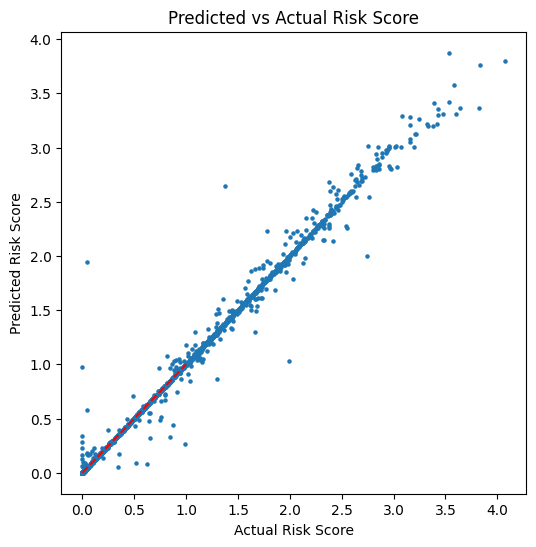

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, pred, s=5)
plt.xlabel("Actual Risk Score")
plt.ylabel("Predicted Risk Score")
plt.title("Predicted vs Actual Risk Score")
plt.plot([0,1],[0,1],'r--')
plt.show()


In [14]:
import joblib
joblib.dump(model, "../models/risk_score_rf.pkl")


['../models/risk_score_rf.pkl']